## Main code 

In [ ]:
# Load the autoreload extension
%load_ext autoreload
%reload_ext autoreload
# Set autoreload to automatically reload all modules before executing code
%autoreload 2

import seq_dataHandler as sdH
import train as models
import numpy as np

#os.environ["WANDB_API_KEY"] = "927dda2d9d05355152f40ca4849f50d69a445e3c"
#wandb.init(entity='paibl', project='strawberry-forecasting')
# Load data
_string_var = ['flower','green', 'sw', 'lw', 'pink', 'red', 'gaps']
n_features = len(_string_var) # check this all time, -1 when red is not a feature
n_folds = 1
seq_l = 3
n_seq = 5
year = 2022
phenological = True
block_size = 4
samples_dim = [seq_l, n_seq, n_features]

yield_path = '/Users/andres/Documents/Strawberry-yield-forecasting/yield_forecasting/data/'+str(year)

# Start pre-processing data
months, days, year = sdH.extract_dates_from_filenames(yield_path,year=year)
#X_Data, y_Data = data_loader(yield_path, months, days, year, _string_var,'', '_x4bs.csv') #legacy input data
X_Data, y_Data = sdH.data_loader(yield_path, months, days, year, _string_var,'','_'+str(block_size)+'.csv')
nX_Data,ny_Data = sdH.normalize_data(X_Data, y_Data,n_features)
#nX_Data,ny_Data = X_Data, y_Data
# Define variables to save X and y test sets per date (for plotting purposes)
_X_per_t = [[[] for _ in range(n_seq)] for _ in range(n_folds)]
_y_per_t = [[[] for _ in range(n_seq)] for _ in range(n_folds)]
_yield_per_t = [[[] for _ in range(n_seq)] for _ in range(n_folds)]
# Get the weights for the phenological classes
W_matrix = sdH.read_weights(None)
#W_matrix = sdH.
# ('/Users/andres/Documents/gaussian_estimator/gaussian_functions.csv')
num_cols = ny_Data.shape[1]+1
num_rows = ny_Data.shape[0]
# Get the sample idx ranges for every fold
_fold_ranges = sdH.get_fold_ranges(n_seq,num_cols,n_folds,ex_dates=1,const=1)# it was 1 at ex_dates
#print(_fold_ranges)
print(_fold_ranges)
for k_fold in range(1,n_folds+1): # Get data for folds
    X_train, y_train, X_test, y_test, _test_yields = [], [], [], [], []
    time_spacing = sdH.time_gaps(months, days, year)
    if n_folds>1: # For two folds
        for row_idx in range(num_rows):
            samples_dim = [seq_l, n_seq, n_features]
            _train_limits = []
            _test_limits = []
            for d_set in range(1,n_folds+1):
                if d_set != k_fold:
                    _train_limits.append(_fold_ranges[d_set-1])
                else:
                    _test_limits.append(_fold_ranges[d_set-1])
            #print(_train_limits,_test_limits)
            # Define train set
            X,y = sdH.get_sequences(samples_dim,row_idx,_train_limits[0][0],_train_limits[0][n_seq],time_spacing,W_matrix,nX_Data,ny_Data,phenological=phenological)
            X_train.append(X)
            y_train.append(y)
            # Define test set
            X,y = sdH.get_sequences(samples_dim,row_idx,_test_limits[0][0],_test_limits[0][n_seq],time_spacing,W_matrix,nX_Data,y_Data,phenological=phenological)
            X_test.append(X)
            y_test.append(y)
            # this block is used to get sequences for the operation (counts x weights)
            _seq_yields = []
            for seq in X:
                seq_yield = 0.0
                for seq_n in seq:
                    seq_yield+=np.sum(seq_n[0:5])
                _seq_yields.append(seq_yield/seq_l)
            _test_yields.append(_seq_yields)
    else:
        num_dates = int(nX_Data.shape[1]/samples_dim[2])
        fold_start = 0
        fold_end = num_dates - samples_dim[0] + 1
        for row_idx in range(num_rows): # For 1 folds, meaning the whole dataset is used for training
            X,y = sdH.get_sequences(samples_dim,row_idx,fold_start,fold_end,time_spacing,W_matrix,nX_Data,ny_Data,phenological=phenological)
            X_train.append(X)
            y_train.append(y)
        k_fold = 0
    # Uncomment this once data for 1 fold is finished
    X_train_extended = np.concatenate(X_train, axis=0)
    y_train_extended = np.concatenate(y_train, axis=0)

    samples_dim = [seq_l, n_seq, n_features] # change n_features for custom num. of features
    # ^^

    #phenological_yield = sdH.get_phenological_yield(X_train_extended, W_matrix, samples_dim) # Check the purpose of this function
    # # This block generates the input data with only red counts as feature
    # X_train_red = []
    # for seq in X_train_extended:
    #     seq_red = []
    #     for seq_i in seq:
    #         _red = []
    #         _red.append(seq_i[5])
    #         seq_red.append(_red)
    #     X_train_red.append(seq_red)
    # X_train_extended = np.array(X_train_red)

    # Train the model
    #model_type = models.train_GRU(100,20,'Adam',samples_dim,k_fold,X_train_extended,y_train_extended,year,block_size,loss='mse',phenological=phenological)
    model_type = models.train_LSTM(100,20,'Adam',samples_dim,k_fold,X_train_extended,y_train_extended,year,block_size,loss='mse',phenological=phenological)
    for loc_x,loc_y,loc_yields in zip(X_test,y_test,_test_yields):
       for idx,input_X in enumerate(loc_x):
           _y_per_t[k_fold-1][idx].append(loc_y[idx])
           _X_per_t[k_fold-1][idx].append(input_X)
           #_X_per_t[k_fold][idx].append(np.array(input_X)[:,5]) #when using only red as feature
           _yield_per_t[k_fold-1][idx].append(loc_yields[idx])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[0, 1, 2, 3, 4, 5]]
Epoch 1/100
40/48 [========================>.....] - ETA: 0s - loss: 0.2845
Epoch 1: val_loss improved from inf to 0.07731, saving model to /Users/andres/Documents/strawberry-forecasting/models/best_GRU_2022_4_35_0_XT.h5
48/48 [==============================] - 2s 10ms/step - loss: 0.2459 - val_loss: 0.0773
Epoch 2/100
35/48 [====================>.........] - ETA: 0s - loss: 0.0371
Epoch 2: val_loss improved from 0.07731 to 0.05494, saving model to /Users/andres/Documents/strawberry-forecasting/models/best_GRU_2022_4_35_0_XT.h5


/opt/anaconda3/envs/forecast/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 0s 4ms/step - loss: 0.0351 - val_loss: 0.0549
Epoch 3/100
46/48 [===========================>..] - ETA: 0s - loss: 0.0294
Epoch 3: val_loss improved from 0.05494 to 0.04594, saving model to /Users/andres/Documents/strawberry-forecasting/models/best_GRU_2022_4_35_0_XT.h5
48/48 [==============================] - 0s 5ms/step - loss: 0.0293 - val_loss: 0.0459
Epoch 4/100
46/48 [===========================>..] - ETA: 0s - loss: 0.0253
Epoch 4: val_loss improved from 0.04594 to 0.04181, saving model to /Users/andres/Documents/strawberry-forecasting/models/best_GRU_2022_4_35_0_XT.h5
48/48 [==============================] - 0s 4ms/step - loss: 0.0252 - val_loss: 0.0418
Epoch 5/100
46/48 [===========================>..] - ETA: 0s - loss: 0.0222
Epoch 5: val_loss improved from 0.04181 to 0.03524, saving model to /Users/andres/Documents/strawberry-forecasting/models/best_GRU_2022_4_35_0_XT.h5
48/48 [==============================] - 0s 4ms/step - loss: 0.0

In [ ]:
# block_size = 6
# lat_d_meters = 233.77/(200)#int(234*1.5)
# lon_d_meters = 204.48/(177)#int(205*1.5)
# gc_size = lat_d_meters*lon_d_meters
# print(gc_size*block_size*block_size)
pixels = len(y_Data[:,14])
cell_size = 21.6 * pixels#33.75
for i in range(1,16):
    #print((i*7)-2)
    print(np.sum(X_Data[:,(i*7)-2]) * (4046.86/cell_size) * (0.6 / 15.0) / 8) 
print(np.sum(y_Data[:,14]) * (4046.86/cell_size) * (0.6 / 15.0) / 8)

### Average yield using $W \cdot X$ 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress

# Sample data
# true_data = <your 2,5,97,1 list>
# predicted_data = <your 2,5,97 list>

# Flatten the last dimension of true_data to match predicted_data
true_data = np.array(_y_per_t)# Removing the last dimension
predicted_data = np.array(_yield_per_t)
# Squeeze the array to remove the last dimension
true_data_flattened = np.squeeze(true_data, axis=-1)
scatter_marker = ['.','d','*','x','+','o','.','x','d','*']
scatter_color = ['black','gray','orange','steelblue','darkviolet','blue','pink','blue','pink','coral']

# Plotting
plt.figure()
_r2 = []
_rmse = []
for time in range(5):
    for fold in range(0,2):
        slope, intercept, r_value, p_value, std_err = linregress(true_data_flattened[fold, time, :], predicted_data[fold, time, :])
        r2 = r_value ** 2
        rmse = np.sqrt(mean_squared_error(true_data_flattened[fold, time], predicted_data[fold, time]))
        plt.scatter(true_data_flattened[fold, time, :], predicted_data[fold, time, :], marker = scatter_marker[time], color=scatter_color[time],label = f'$t_{time}$, $R^2$= {r2:.2f}, RMSE= {rmse:.2f}')
        _r2.append(r2)
        _rmse.append(rmse)
print(np.mean(_r2), np.mean(_rmse))

plt.title(f'Scatter Plot for Time Groups')
plt.xlabel('True yield (Norm.)')
plt.ylabel('Predicted yield (Norm.)')
plt.legend()
plt.tight_layout()
plt.show()

### Plot cross-val. results

In [202]:
y_Data.shape

(97, 15)

In [ ]:
import matplotlib.pyplot as plt

# Example single dataset
data = y_Data

# Plot histogram
plt.figure(figsize=(4, 4))
plt.hist(data[:,14], bins=100, alpha=0.7)

# Add labels and title
#plt.title('Histogram of the Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show plot
plt.show()

2/2 [==============================] - 0s 3ms/step
(52, 1) (52, 1)
2/2 [==============================] - 0s 2ms/step
(52, 1) (52, 1)
2/2 [==============================] - 0s 2ms/step
(52, 1) (52, 1)
2/2 [==============================] - 0s 2ms/step
(52, 1) (52, 1)
2/2 [==============================] - 0s 2ms/step
(52, 1) (52, 1)


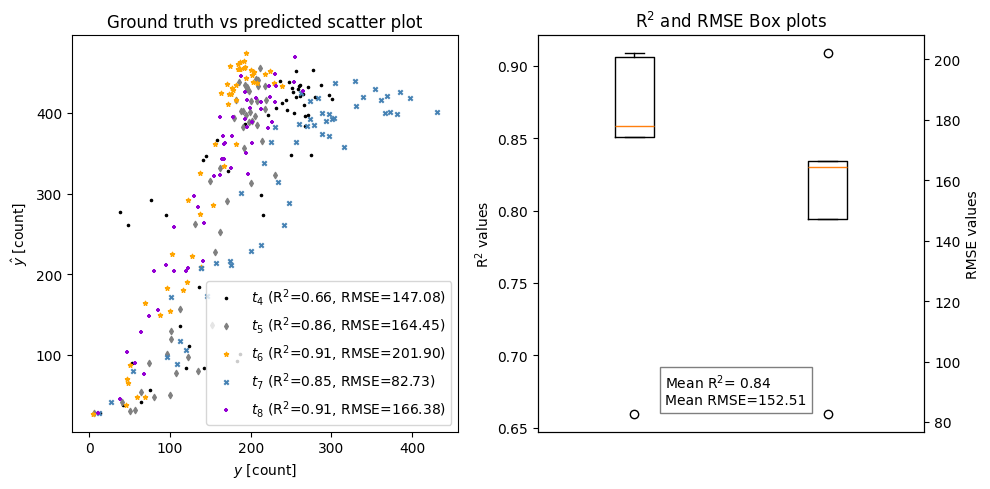

2/2 [==============================] - 0s 3ms/step
(52, 1) (52, 1)
2/2 [==============================] - 0s 2ms/step
(52, 1) (52, 1)
2/2 [==============================] - 0s 2ms/step
(52, 1) (52, 1)
2/2 [==============================] - 0s 3ms/step
(52, 1) (52, 1)
2/2 [==============================] - 0s 2ms/step
(52, 1) (52, 1)


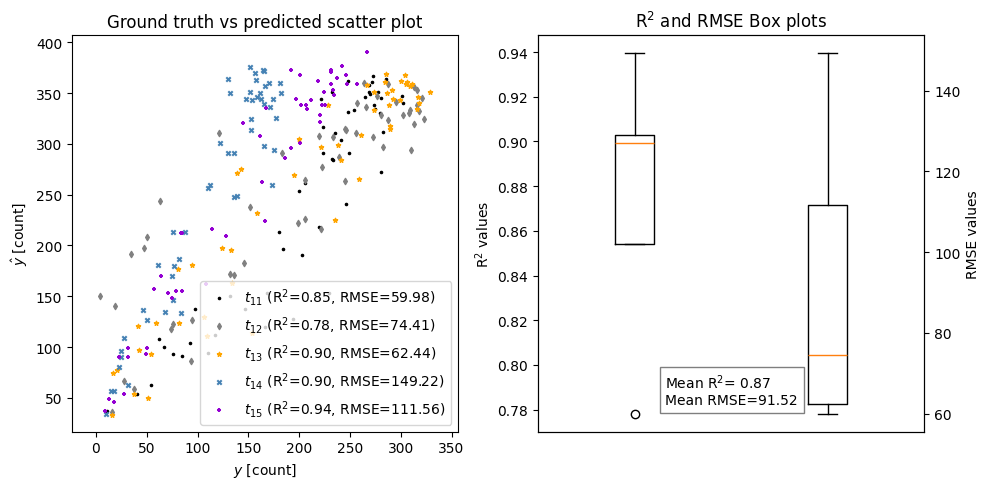

Mean R2= 0.855847529905734
Mean RMSE= 122.01515189369745


In [32]:
%reload_ext autoreload
%autoreload 2
import visualize as vis
model_name = 'best_'+model_type
_r2 = []
_rmse = []
for k_fold in range(n_folds):
    if k_fold == 0:
        rmse, r2 = vis.kfold_plot(model_name,_X_per_t,_y_per_t,samples_dim,y_Data[:,:7],year,k_fold,block_size,err_metric='RMSE',phenological=phenological)
    else:
        rmse, r2 = vis.kfold_plot(model_name,_X_per_t,_y_per_t,samples_dim,y_Data[:,7:],year,k_fold,block_size,err_metric='RMSE',phenological=phenological)
    _r2.append(r2)
    _rmse.append(rmse)
print('Mean R2=',np.mean(_r2))
print('Mean RMSE=',np.mean(_rmse))

## Test models on one whole year dataset.

### Get test input data for a year.

In [68]:
# Load the autoreload extension
%load_ext autoreload
%reload_ext autoreload
# Set autoreload to automatically reload all modules before executing code
%autoreload 2

import seq_dataHandler as sdH
import train as models
import numpy as np

#os.environ["WANDB_API_KEY"] = "927dda2d9d05355152f40ca4849f50d69a445e3c"
#wandb.init(entity='paibl', project='strawberry-forecasting')
# Load data
_string_var = ['flower','green', 'sw', 'lw', 'pink', 'red', 'gaps']
n_features = len(_string_var) # check this all time, -1 when red is not a feature
n_folds = 1
seq_l = 3
n_seq = 5
test_year = 2023
phenological = True
block_size = 4
samples_dim = [seq_l, n_seq, n_features]
if test_year == 2023:
    yield_path = '/Users/andres/Documents/yield_data/output/2023/'
else:
    yield_path = '/Users/andres/Documents/yield_data/output_yolov10/'
# Start pre-processing data
months, days, year = sdH.extract_dates_from_filenames(yield_path,year=test_year)
#X_Data, y_Data = data_loader(yield_path, months, days, year, _string_var,'', '_x4bs.csv') #legacy input data
X_Data, y_Data = sdH.data_loader(yield_path, months, days, year, _string_var,'','_'+str(block_size)+'.csv')
nX_Data,ny_Data = sdH.normalize_data(X_Data, y_Data,n_features)
#nX_Data,ny_Data = X_Data, y_Data

# Get the weights for the phenological classes
W_matrix = sdH.read_weights(None)
#W_matrix = sdH.read_weights('/Users/andres/Documents/gaussian_estimator/gaussian_functions.csv')
num_cols = ny_Data.shape[1]+1
num_rows = ny_Data.shape[0]
# Get the sample idx ranges for every fold
#_fold_ranges = sdH.get_fold_ranges(n_seq,num_cols,n_folds,ex_dates=1,const=1)# it was 1 at ex_dates
#print(_fold_ranges)
samples_dim = [seq_l, n_seq, n_features]
X_test, y_test = [], []
time_spacing = sdH.time_gaps(months, days, year)

num_dates = int(nX_Data.shape[1]/samples_dim[2])
# Define variables to save X and y test sets per date (for plotting purposes)
_X_per_t = [[] for _ in range(num_dates-samples_dim[0]+1)]
_y_per_t = [[] for _ in range(num_dates-samples_dim[0]+1)]
fold_start = 0
fold_end = num_dates - samples_dim[0] + 1
for row_idx in range(num_rows): # For 1 folds, meaning the whole dataset is used for training
    X,y = sdH.get_sequences(samples_dim,row_idx,fold_start,fold_end,time_spacing,W_matrix,nX_Data,y_Data,phenological=phenological)
    X_test.append(X)
    y_test.append(y)
k_fold = n_folds-1

for loc_x,loc_y in zip(X_test,y_test):
   for time_t,input_X in enumerate(loc_x):
       #print(time_t,input_X)
       _y_per_t[time_t].append(loc_y[time_t])
       _X_per_t[time_t].append(input_X)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
np.max(_y_per_t)

356.01666666666665

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

data = _y_per_t
#Create a figure for the histograms
colors = ['black','dimgray','slategray','turquoise','deepskyblue','blue','darkviolet','violet','pink','orange','sandybrown','brown', 'gold']

plt.figure(figsize=(10, 6))
# Loop over the sublists
for i, sublist in enumerate(data[:]):
    int_list = [int(np.array(x)) for x in sublist]
    # Compute and plot the KDE curve
    kde = gaussian_kde(int_list)
    x_range = np.linspace(min(int_list), max(int_list), 100)
    plt.plot(x_range, kde(x_range), color=colors[i],label=f't_ {i+samples_dim[0]}')
# Show the legend
plt.legend(loc='upper right', ncol=2)
# Show the plot
plt.show()

7/7 [==============================] - 0s 1ms/step
-2.1286886583177465 160.84939407400117
3
7/7 [==============================] - 0s 1ms/step
-1.7551647740384722 152.76148853523992
4
7/7 [==============================] - 0s 1ms/step
-5.341701801924166 206.8583306254992
5
7/7 [==============================] - 0s 1ms/step
0.9428021271559267 55.37708889810305
6
7/7 [==============================] - 0s 1ms/step
0.740135818989322 93.66650027460364
7
7/7 [==============================] - 0s 1ms/step
-1.4390923708853123 135.39239611849746
8
7/7 [==============================] - 0s 1ms/step
-0.5865227298363467 163.51340422297378
9
7/7 [==============================] - 0s 1ms/step
0.6302809807547338 99.97926903318942
10
7/7 [==============================] - 0s 1ms/step
0.6803830918224272 86.09848215295368
11
7/7 [==============================] - 0s 1ms/step
-2.557235772277869 187.90525087379783
12
7/7 [==============================] - 0s 1ms/step
0.6594204399067218 102.37102043469268


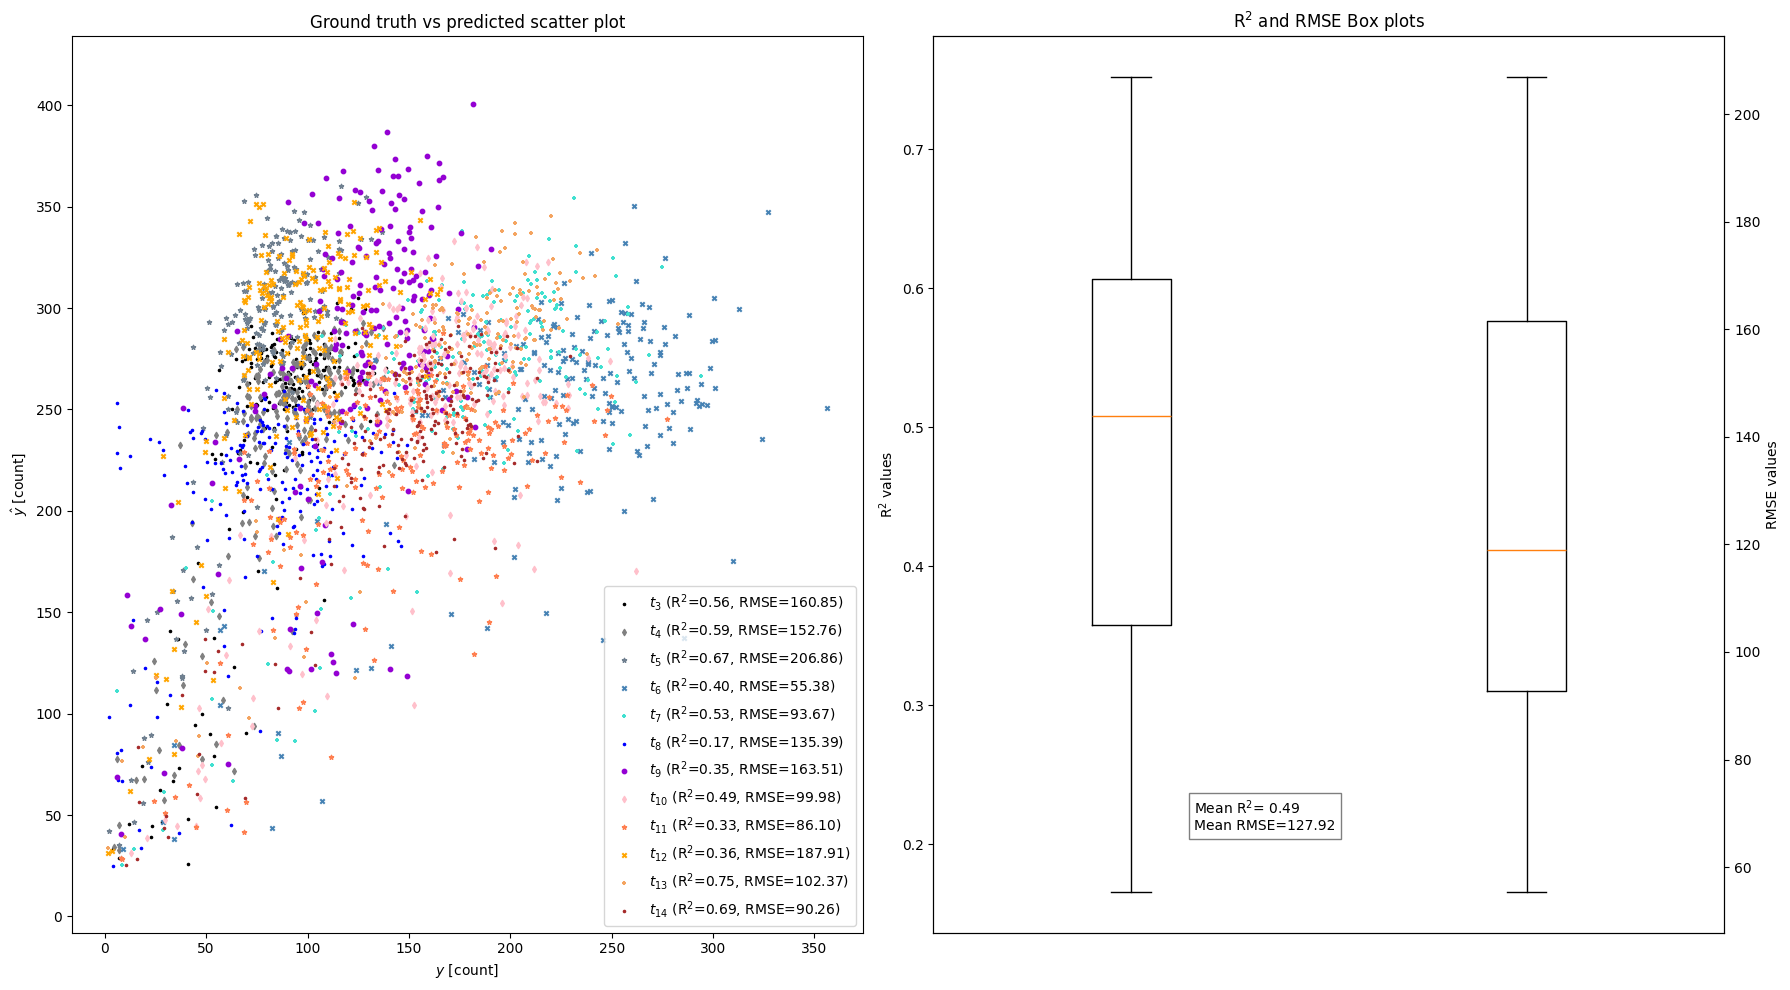

Mean R2= 0.48931963141485174
Mean RMSE= 127.91904951383235


In [70]:
%reload_ext autoreload
%autoreload 2
import visualize as vis
#model_name = 'best_LSTM'#
model_name = 'best_GRU'
if test_year == 2022:
    model_year=2023 # Year for trained model
else:
    model_year=2022
#model_year=test_year
_r2 = []
_rmse = []
rmse, r2 = vis.yearly_plot(model_name,_X_per_t,_y_per_t,samples_dim,y_Data,model_year,k_fold,block_size,err_metric='RMSE',phenological=phenological,save=False)
_r2.append(r2)
_rmse.append(rmse)
print('Mean R2=',np.mean(_r2))
print('Mean RMSE=',np.mean(_rmse))

## Train with half 2022 and half 2023 data

In [33]:
# Load the autoreload extension
%load_ext autoreload
%reload_ext autoreload
# Set autoreload to automatically reload all modules before executing code
%autoreload 2

import seq_dataHandler as sdH
import train as models
import numpy as np

#os.environ["WANDB_API_KEY"] = "927dda2d9d05355152f40ca4849f50d69a445e3c"
#wandb.init(entity='paibl', project='strawberry-forecasting')
# Load data
_string_var = ['flower','green', 'sw', 'lw', 'pink', 'red', 'gaps']
n_features = len(_string_var) # check this all time, -1 when red is not a feature
n_folds = 2
seq_l = 3
n_seq = 5
phenological = True
block_size = 4
samples_dim = [seq_l, n_seq, n_features]

yield_path_2023 = '/Users/andres/Documents/yield_data/output/2023/'
yield_path_2022 = '/Users/andres/Documents/yield_data/output_yolov10/'

# Start pre-processing data
months, days, year = sdH.extract_dates_from_filenames(yield_path_2022,year=2022)
X_Data_2022, y_Data_2022 = sdH.data_loader(yield_path_2022, months, days, str(2022), _string_var,'','_'+str(block_size)+'.csv')
time_spacing_2022 = sdH.time_gaps(months, days, year)
months, days, year = sdH.extract_dates_from_filenames(yield_path_2023,year=2023)
X_Data_2023, y_Data_2023 = sdH.data_loader(yield_path_2023, months, days, str(2023), _string_var,'','_'+str(block_size)+'.csv')
time_spacing_2023 = sdH.time_gaps(months, days, year)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
newX_Data_2022 = X_Data_2022[:, :-7]

#newX_Data_2022.shape, X_Data_2023.shape
merged_X_Data = np.vstack((newX_Data_2022, X_Data_2023))

print(merged_X_Data.shape)

(307, 98)


In [35]:
newy_Data_2022 = y_Data_2022[:, :-1]
#newy_Data_2022.shape, y_Data_2023.shape
merged_y_Data = np.vstack((newy_Data_2022, y_Data_2023))

print(merged_y_Data.shape)

(307, 14)


In [36]:
nX_Data,ny_Data = sdH.normalize_data(merged_X_Data, merged_y_Data,n_features)
print(nX_Data.shape, ny_Data.shape)

(307, 98) (307, 14)


In [47]:
print(time_spacing_2022)
new_time_spacing_2022 = time_spacing_2022[:-1]
print(new_time_spacing_2022)

[11, 7, 3, 7, 4, 7, 3, 4, 3, 4, 3, 17, 3, 19, 2]
[11, 7, 3, 7, 4, 7, 3, 4, 3, 4, 3, 17, 3, 19]


In [37]:
time_spacing_2023

[5, 14, 14, 7, 7, 2, 12, 7, 1, 6, 14, 1, 6, 7]

In [38]:
_X_per_t = [[[] for _ in range(n_seq)] for _ in range(n_folds)]
_y_per_t = [[[] for _ in range(n_seq)] for _ in range(n_folds)]
_yield_per_t = [[[] for _ in range(n_seq)] for _ in range(n_folds)]

In [39]:
W_matrix = sdH.read_weights(None)
num_cols = ny_Data.shape[1]+1
num_rows = ny_Data.shape[0]
_fold_ranges = sdH.get_fold_ranges(n_seq,num_cols,n_folds,ex_dates=1,const=1)# it was 1 at ex_dates

In [40]:
print(_fold_ranges)

[[0, 1, 2, 3, 4, 5], [7, 8, 9, 10, 11, 12]]


In [48]:
for k_fold in range(1,n_folds+1): # Get data for folds
    X_train, y_train, X_test, y_test, _test_yields = [], [], [], [], []
    time_spacing = sdH.time_gaps(months, days, year)
    if n_folds>1: # For two folds
        for row_idx in range(num_rows):
            samples_dim = [seq_l, n_seq, n_features]
            _train_limits = []
            _test_limits = []
            for d_set in range(1,n_folds+1):
                if d_set != k_fold:
                    _train_limits.append(_fold_ranges[d_set-1])
                else:
                    _test_limits.append(_fold_ranges[d_set-1])
            #print(_train_limits,_test_limits)
            # Define train set
            X,y = sdH.get_sequences(samples_dim,row_idx,_train_limits[0][0],_train_limits[0][n_seq],time_spacing,W_matrix,nX_Data,ny_Data,phenological=phenological)
            X_train.append(X)
            y_train.append(y)
            # Define test set
            X,y = sdH.get_sequences(samples_dim,row_idx,_test_limits[0][0],_test_limits[0][n_seq],time_spacing,W_matrix,nX_Data,merged_y_Data,phenological=phenological)
            X_test.append(X)
            y_test.append(y)
            # this block is used to get sequences for the operation (counts x weights)
            _seq_yields = []
            for seq in X:
                seq_yield = 0.0
                for seq_n in seq:
                    seq_yield+=np.sum(seq_n[0:5])
                _seq_yields.append(seq_yield/seq_l)
            _test_yields.append(_seq_yields)
    else:
        num_dates = int(nX_Data.shape[1]/samples_dim[2])
        fold_start = 0
        fold_end = num_dates - samples_dim[0] + 1
        for row_idx in range(num_rows): # For 1 folds, meaning the whole dataset is used for training
            X,y = sdH.get_sequences(samples_dim,row_idx,fold_start,fold_end,time_spacing,W_matrix,nX_Data,ny_Data,phenological=phenological)
            X_train.append(X)
            y_train.append(y)
        k_fold = 0
    # Uncomment this once data for 1 fold is finished
    X_train_extended = np.concatenate(X_train, axis=0)
    y_train_extended = np.concatenate(y_train, axis=0)

    samples_dim = [seq_l, n_seq, n_features] # change n_features for custom num. of features
    # ^^

    #phenological_yield = sdH.get_phenological_yield(X_train_extended, W_matrix, samples_dim) # Check the purpose of this function

    # # This block generates the input data with only red counts as feature
    # X_train_red = []
    # for seq in X_train_extended:
    #     seq_red = []
    #     for seq_i in seq:
    #         _red = []
    #         _red.append(seq_i[5])
    #         seq_red.append(_red)
    #     X_train_red.append(seq_red)
    # X_train_extended = np.array(X_train_red)

    # Train the model
    #model_type = models.train_GRU(100,20,'Adam',samples_dim,k_fold,X_train_extended,y_train_extended,20222023,block_size,loss='mse',phenological=phenological)
    model_type = models.train_LSTM(100,20,'Adam',samples_dim,k_fold,X_train_extended,y_train_extended,20222023,block_size,loss='mse',phenological=phenological)
    for loc_x,loc_y,loc_yields in zip(X_test,y_test,_test_yields):
       for idx,input_X in enumerate(loc_x):
           _y_per_t[k_fold-1][idx].append(loc_y[idx])
           _X_per_t[k_fold-1][idx].append(input_X)
           #_X_per_t[k_fold][idx].append(np.array(input_X)[:,5]) #when using only red as feature
           _yield_per_t[k_fold-1][idx].append(loc_yields[idx])


Epoch 1/100
55/58 [===========================>..] - ETA: 0s - loss: 0.2022
Epoch 1: val_loss improved from inf to 0.02814, saving model to /Users/andres/Documents/strawberry-forecasting/models/best_LSTM_20222023_4_35_1_XT.h5
58/58 [==============================] - 3s 9ms/step - loss: 0.1955 - val_loss: 0.0281
Epoch 2/100
58/58 [==============================] - ETA: 0s - loss: 0.0385
Epoch 2: val_loss improved from 0.02814 to 0.02726, saving model to /Users/andres/Documents/strawberry-forecasting/models/best_LSTM_20222023_4_35_1_XT.h5
58/58 [==============================] - 0s 5ms/step - loss: 0.0385 - val_loss: 0.0273
Epoch 3/100
57/58 [============================>.] - ETA: 0s - loss: 0.0364
Epoch 3: val_loss improved from 0.02726 to 0.02538, saving model to /Users/andres/Documents/strawberry-forecasting/models/best_LSTM_20222023_4_35_1_XT.h5
58/58 [==============================] - 0s 5ms/step - loss: 0.0364 - val_loss: 0.0254
Epoch 4/100
57/58 [============================>.] - 

In [ ]:
np.array(X_test).shape
X_test[0]

In [ ]:
_X_per_t[1][0]

## Get results

39/39 [==============================] - 0s 2ms/step
(1228, 1) (1228, 1)
39/39 [==============================] - 0s 1ms/step
(1228, 1) (1228, 1)
39/39 [==============================] - 0s 1ms/step
(1228, 1) (1228, 1)
39/39 [==============================] - 0s 1ms/step
(1228, 1) (1228, 1)
39/39 [==============================] - 0s 1ms/step
(1228, 1) (1228, 1)


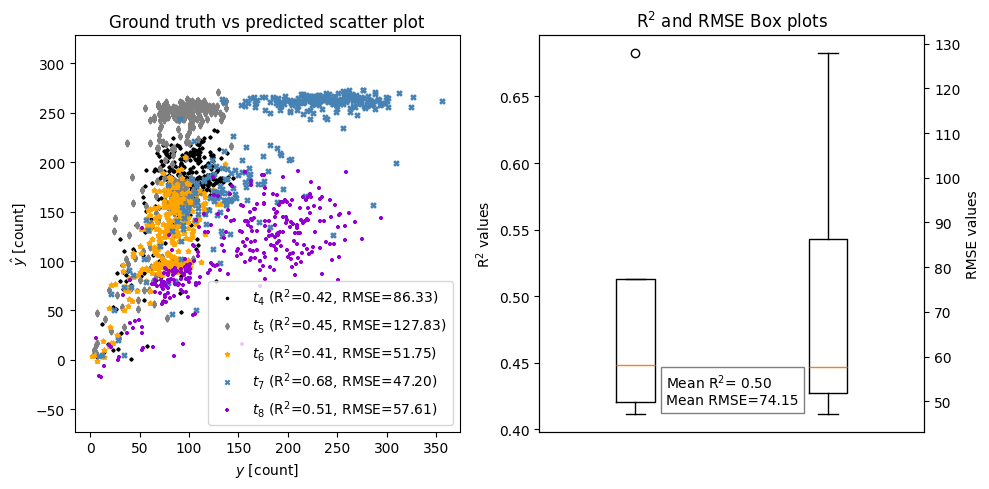

39/39 [==============================] - 0s 1ms/step
(1228, 1) (1228, 1)
39/39 [==============================] - 0s 1ms/step
(1228, 1) (1228, 1)
39/39 [==============================] - 0s 1ms/step
(1228, 1) (1228, 1)
39/39 [==============================] - 0s 1ms/step
(1228, 1) (1228, 1)
39/39 [==============================] - 0s 1ms/step
(1228, 1) (1228, 1)


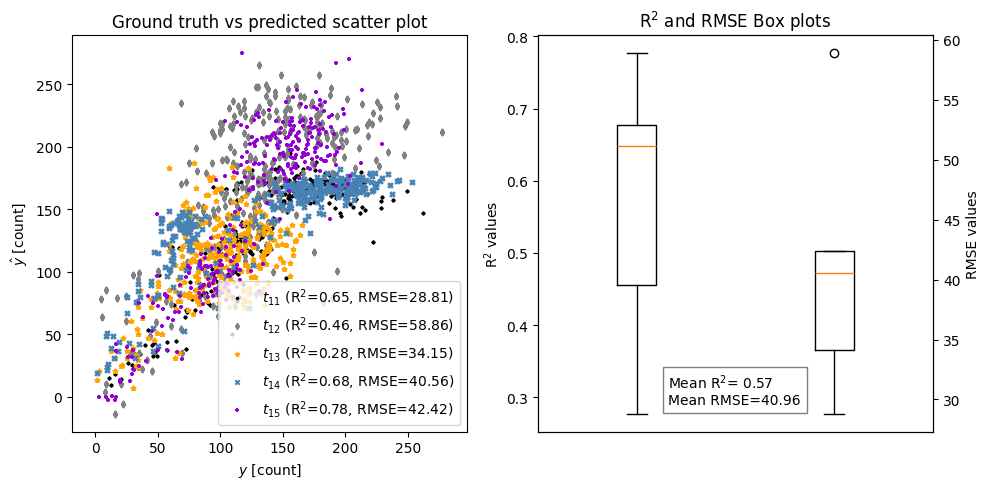

Mean R2= 0.530934399432316
Mean RMSE= 57.55445673329599


In [49]:
%reload_ext autoreload
%autoreload 2
import visualize as vis
model_name = 'best_'+model_type#
_r2 = []
_rmse = []
for k_fold in range(n_folds):
    if k_fold == 0:
        rmse, r2 = vis.kfold_plot(model_name,_X_per_t,_y_per_t,samples_dim,merged_y_Data[:,:7],20222023,k_fold,block_size,err_metric='RMSE',phenological=phenological)
    else:
        rmse, r2 = vis.kfold_plot(model_name,_X_per_t,_y_per_t,samples_dim,merged_y_Data[:,7:],20222023,k_fold,block_size,err_metric='RMSE',phenological=phenological)
    _r2.append(r2)
    _rmse.append(rmse)
print('Mean R2=',np.mean(_r2))
print('Mean RMSE=',np.mean(_rmse))

### Save data from trainings.

In [147]:
#ADD to above to save data
import csv
import os

# Flatten the innermost dimension to match the CSV format
y_true_flat = [list(map(lambda x: x[0], sublist)) for sublist in _y_true]
y_hat_flat = [list(map(lambda x: x[0], sublist)) for sublist in _y_hat]

# Transpose the data to match the CSV format (columns -> rows)
T_true = list(zip(*y_true_flat))
T_pred = list(zip(*y_hat_flat))

# Specify the filename
filename_true = '/Users/andres/Documents/strawberry-forecasting/'+csv_str+'true_'+str(k_fold)+'.csv'
filename_pred = '/Users/andres/Documents/strawberry-forecasting/'+csv_str+'pred_'+str(k_fold)+'.csv'

# Check if the file exists and delete it if it does
if os.path.exists(filename_true):
    os.remove(filename_true)
if os.path.exists(filename_pred):
    os.remove(filename_pred)
# Write the data to a CSV file
with open(filename_true, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(T_true)
with open(filename_pred, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(T_pred)

if phenological:
    if k_fold ==0:
        true_trend_0 = []
        pred_trend_XT_0 = []
        print('phenological fold 0')
        for true_sum,pred_sum in zip(_y_true,_y_hat):
            true_trend_0.append(np.sum(true_sum))
            pred_trend_XT_0.append(np.sum(pred_sum))
    else:
        print('phenological fold 1')
        true_trend_1 = []
        pred_trend_XT_1 = []
        for true_sum,pred_sum in zip(_y_true,_y_hat):
            true_trend_1.append(np.sum(true_sum))
            pred_trend_XT_1.append(np.sum(pred_sum))       
else:
    if k_fold ==0:
        print('regular fold 0')
        true_trend_0 = []
        pred_trend_X_0 = []
        for true_sum,pred_sum in zip(_y_true,_y_hat):
            true_trend_0.append(np.sum(true_sum))
            pred_trend_X_0.append(np.sum(pred_sum))
    else:
        true_trend_1 = []
        pred_trend_X_1 = []
        print('regular fold 1')
        for true_sum,pred_sum in zip(_y_true,_y_hat):
            true_trend_1.append(np.sum(true_sum))
            pred_trend_X_1.append(np.sum(pred_sum)) 

phenological fold 1


## Plot for trend prediction vs true

In [18]:
import matplotlib.pyplot as plt
from datetime import datetime

fold_plot = 0
if fold_plot == 0:
    print('fold plot 0')
    trend_dates = ['07/05/22', '07/08/22', '07/15/22', '07/19/22', '07/26/22']
    true_trend = true_trend_0
    pred_trend_XT = pred_trend_XT_0
    pred_trend_X = pred_trend_X_0
else:
    print('fold plot 1')
    trend_dates = ['08/09/22', '08/12/22', '08/29/22', '09/01/22', '09/20/22']
    true_trend = true_trend_1
    pred_trend_XT = pred_trend_XT_1
    pred_trend_X = pred_trend_X_1

# Sample data
dates = trend_dates

# Convert date strings to datetime objects
dates = [datetime.strptime(date, "%m/%d/%y") for date in dates]
#date_objects = [datetime.strptime(f'{date}', '%m/%d/%y') for date in dates]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(dates, true_trend, label='True Yield', marker='o', color='red', linestyle='--')
plt.plot(dates, pred_trend_X, label=r'Predicted Yield ($X$)', marker='o', color='black')
plt.plot(dates, pred_trend_XT, label=r'Predicted Yield ($\tilde X$)', marker='o', color='blue')
plt.xlabel('Date', fontdict={'fontname': 'PT Serif', 'fontsize': 14})
plt.ylabel('Yield [count]', fontdict={'fontname': 'PT Serif', 'fontsize': 14})
#plt.title('True Yield vs Predicted Yield')
plt.legend(prop={'family': 'PT Serif', 'size': 12})
plt.grid(True)
plt.xticks(dates)
plt.xticks(rotation=45, fontname='PT Serif', fontsize=12)
plt.yticks(fontname='PT Serif', fontsize=12)
plt.tight_layout()
plt.savefig('/Users/andres/Documents/yield_data/X2_yield_'+str(fold_plot)+'.pdf', dpi=300)

plt.show()

fold plot 0


NameError: name 'true_trend_0' is not defined

In [159]:
np.array(true_trend).shape

(0,)

Sklearn R-squared: 0.54
Scipy R-squared: 0.76


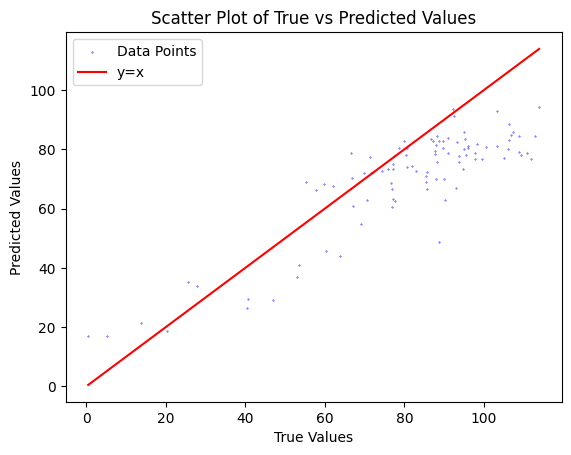

Sklearn R-squared: 0.52
Scipy R-squared: 0.56


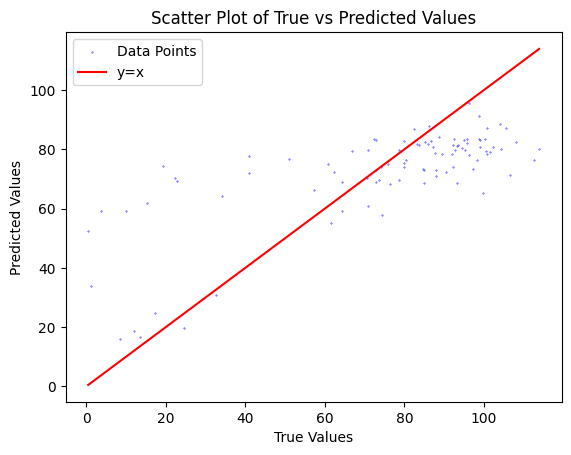

Sklearn R-squared: 0.73
Scipy R-squared: 0.78


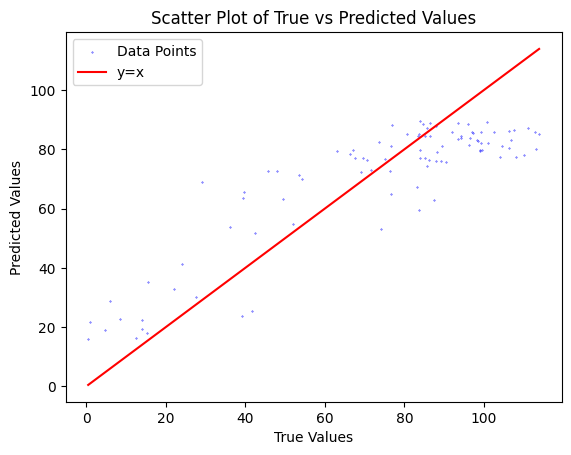

Sklearn R-squared: 0.58
Scipy R-squared: 0.63


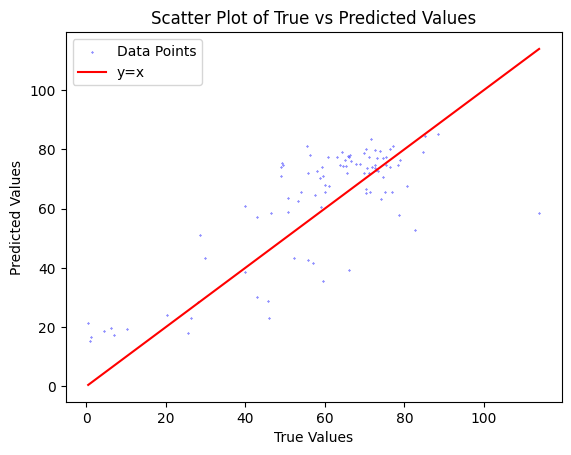

Sklearn R-squared: 0.63
Scipy R-squared: 0.79


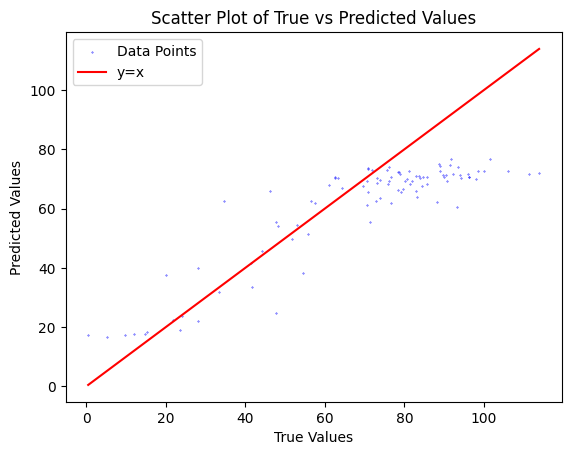

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import linregress

# Example arrays (replace these with your actual data)
for y_true, y_hat in zip(_y_true,_y_hat):
    true_values = y_true
    predicted_values = y_hat

    # Compute r squared score
    r_squared = r2_score(true_values, predicted_values)
    print(f'Sklearn R-squared: {r_squared:.2f}')

    slope, intercept, r_value, p_value, std_err = linregress(np.ravel(true_values), np.ravel(predicted_values))
    #print(np.ravel(true_values).shape)
    r_squared = r_value ** 2
    print(f'Scipy R-squared: {r_squared:.2f}')

    # Create scatter plot
    plt.scatter(true_values, predicted_values, s=0.1,c='blue', label='Data Points')

    # Add a line y=x for reference
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', label='y=x')

    # Add labels and title
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot of True vs Predicted Values')
    plt.legend()

    # Show plot
    plt.show()

In [31]:
_y_true[0][79]


array([132.47255359])

In [294]:
flattened_y = y_Data.flatten().reshape(-1, 1)
y_gt_scaler = MinMaxScaler(feature_range=(0.0, 1.0))
y_fit = y_gt_scaler.fit(flattened_y)
single_feat = np.zeros((126,1))
single_feat[0][0] = 1
extended_array = np.zeros((flattened_y.shape[0], 1))
extended_array[:single_feat.shape[0], :] = single_feat
new_y = y_fit.inverse_transform(extended_array)
new_y[0]

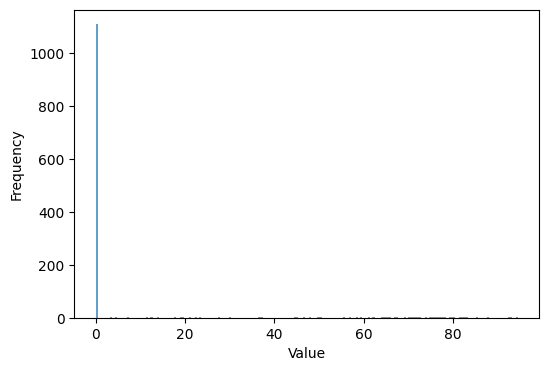

In [462]:
import matplotlib.pyplot as plt

# Assuming `data` is your (126, 15) array
flattened_y = y_Data.flatten().reshape(-1, 1)
plt.figure(figsize=(6, 4))
plt.hist(_y_true[1], bins=200, alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Main code 2023

In [21]:
n_folds = 2
_string_var = ['flower','green', 'sw', 'lw', 'pink', 'red', 'gaps']
n_features = len(_string_var) # check this all time
n_folds = 2
seq_l = 3
n_seq = 6
samples_dim = [seq_l, n_seq, n_features]
yield_path = '/Users/andres/Documents/yield_data/experimental_yield_2023/'
months, days, year = extract_dates_from_filenames(yield_path,year=2023)
X_Data, y_Data = data_loader(yield_path, months, days, year, _string_var,'exp_yield_','_4.csv')
nX_Data,ny_Data = normalize_data(X_Data,y_Data,n_features)

# Get data for folds
# Define variables to save X and y test sets per date (for plotting purposes)
_X_per_t = [[[] for _ in range(n_seq)] for _ in range(n_folds)]
_y_per_t = [[[] for _ in range(n_seq)] for _ in range(n_folds)]
# Get the weights for the phenological classes
W_matrix = read_weights('/Users/andres/Documents/strawberry-forecasting/scripts/weights_new.csv')
num_cols = y_Data.shape[1]+1
num_rows = y_Data.shape[0]
# Get the sample idx ranges for every fold
_fold_ranges = get_fold_ranges(n_seq,num_cols,n_folds,ex_dates=2,const=1) # find a better way to get ranges
print(_fold_ranges)
#os.environ["WANDB_API_KEY"] = "927dda2d9d05355152f40ca4849f50d69a445e3c"
#wandb.init(entity='paibl', project='strawberry-forecasting')
for k_fold in range(n_folds):
    X_train, y_train, X_test, y_test = [], [], [], []
    time_spacing = time_gaps(months, days, year)
    for row_idx in range(num_rows):
        _train_limits = []
        _test_limits = []
        for d_set in range(n_folds):
            if d_set != k_fold:
                _train_limits.append(_fold_ranges[d_set])
            else:
                _test_limits.append(_fold_ranges[d_set])
        # Define train set
        #print(_train_limits[0])
        #print(len(X_Data[0]))
        X,y = get_sequences(samples_dim,row_idx,_train_limits[0][0],_train_limits[0][n_seq],time_spacing,W_matrix,nX_Data,ny_Data)
        X_train.append(X)
        y_train.append(y)
        # Define test set
        X,y = get_sequences(samples_dim,row_idx,_test_limits[0][0],_test_limits[0][n_seq],time_spacing,W_matrix,nX_Data,ny_Data)
        X_test.append(X)
        y_test.append(y)
    X_train_extended = np.concatenate(X_train, axis=0)
    y_train_extended = np.concatenate(y_train, axis=0)
    # train model
    train_model(100,32,'Adam',samples_dim,k_fold,X_train_extended,y_train_extended,'best_model_2023_',loss='mse')
    for loc_x,loc_y in zip(X_test,y_test):
        for idx,input_X in enumerate(loc_x):
             _y_per_t[k_fold][idx].append(loc_y[idx])
             _X_per_t[k_fold][idx].append(input_X)

[[0, 1, 2, 3, 4, 5, 6], [8, 9, 10, 11, 12, 13, 14]]
14
12
5
20
13
8
19
14
6
28
20
14
21
15
1
21
7
6
21
12
7
19
14
7
28
21
14
28
21
7
23
9
2
14
7
5
14
12
5
20
13
8
19
14
6
28
20
14
21
15
1
21
7
6
21
12
7
19
14
7
28
21
14
28
21
7
23
9
2
14
7
5
14
12
5
20
13
8
19
14
6
28
20
14
21
15
1
21
7
6
21
12
7
19
14
7
28
21
14
28
21
7
23
9
2
14
7
5
14
12
5
20
13
8
19
14
6
28
20
14
21
15
1
21
7
6
21
12
7
19
14
7
28
21
14
28
21
7
23
9
2
14
7
5
14
12
5
20
13
8
19
14
6
28
20
14
21
15
1
21
7
6
21
12
7
19
14
7
28
21
14
28
21
7
23
9
2
14
7
5
14
12
5
20
13
8
19
14
6
28
20
14
21
15
1
21
7
6
21
12
7
19
14
7
28
21
14
28
21
7
23
9
2
14
7
5
14
12
5
20
13
8
19
14
6
28
20
14
21
15
1
21
7
6
21
12
7
19
14
7
28
21
14
28
21
7
23
9
2
14
7
5
14
12
5
20
13
8
19
14
6
28
20
14
21
15
1
21
7
6
21
12
7
19
14
7
28
21
14
28
21
7
23
9
2
14
7
5
14
12
5
20
13
8
19
14
6
28
20
14
21
15
1
21
7
6
21
12
7
19
14
7
28
21
14
28
21
7
23
9
2
14
7
5
14
12
5
20
13
8
19
14
6
28
20
14
21
15
1
21
7
6
21
12
7
19
14
7
28
21
14
28
21
7
23
9
2
14
7


/opt/anaconda3/envs/forecast/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.04677 to 0.03480, saving model to /Users/andres/Documents/strawberry-forecasting/models/best_model_2023_0_XT.h5
38/38 [==============================] - 0s 6ms/step - loss: 0.0643 - val_loss: 0.0348
Epoch 3/100
28/38 [=====================>........] - ETA: 0s - loss: 0.0493
Epoch 3: val_loss improved from 0.03480 to 0.03291, saving model to /Users/andres/Documents/strawberry-forecasting/models/best_model_2023_0_XT.h5
38/38 [==============================] - 0s 7ms/step - loss: 0.0462 - val_loss: 0.0329
Epoch 4/100
26/38 [===================>..........] - ETA: 0s - loss: 0.0465
Epoch 4: val_loss improved from 0.03291 to 0.03209, saving model to /Users/andres/Documents/strawberry-forecasting/models/best_model_2023_0_XT.h5
38/38 [==============================] - 0s 5ms/step - loss: 0.0441 - val_loss: 0.0321
Epoch 5/100
26/38 [===================>..........] - ETA: 0s - loss: 0.0461
Epoch 5: val_loss did not improve from 0.03209
38/38 [==================

8/8 [==============================] - 0s 1ms/step


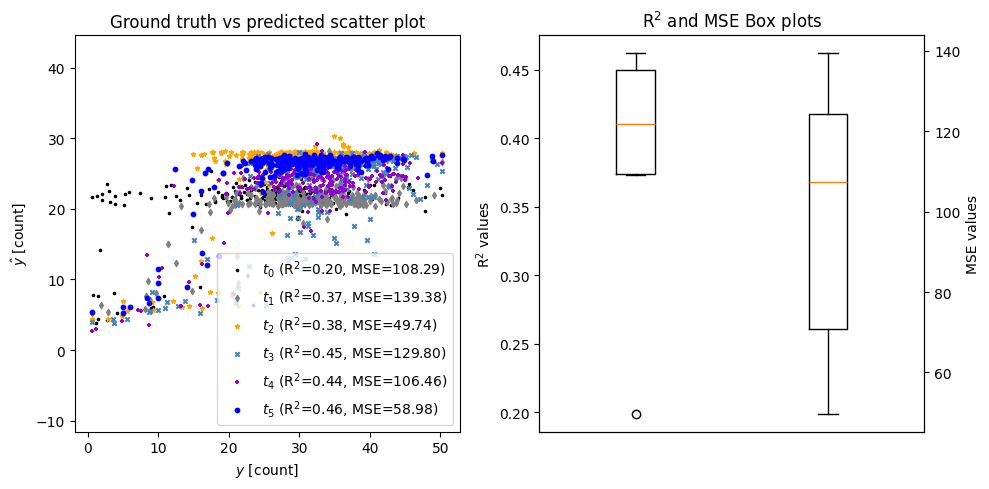

In [23]:
#2023
model_path = '/Users/andres/Documents/strawberry-forecasting/models/best_model_2023_'
output_path = '/Users/andres/Documents/strawberry-forecasting/images/'

kfold_plot(model_path,output_path,_X_per_t,_y_per_t,samples_dim,y_Data,year=2023,k_fold=0,err_metric='MSE')

In [209]:
import os
import shutil

# Define the main folder path
main_folder = '/Users/andres/Documents/strawberry-forecasting/2023_sequences'

# Create cam1 and cam2 subfolders
cam1_folder = os.path.join(main_folder, 'cam1')
cam2_folder = os.path.join(main_folder, 'cam2')

# Create the subdirectories if they don't exist
os.makedirs(cam1_folder, exist_ok=True)
os.makedirs(cam2_folder, exist_ok=True)

# Iterate through the files in the main folder
for filename in os.listdir(main_folder):
    # Get the full path of the image
    file_path = os.path.join(main_folder, filename)
    
    # Check if it is a file (not a directory)
    if os.path.isfile(file_path):
        # Move files to the corresponding subfolder based on their name
        if filename.endswith('_cam1.jpg'):
            shutil.move(file_path, os.path.join(cam1_folder, filename))
        elif filename.endswith('_cam2.jpg'):
            shutil.move(file_path, os.path.join(cam2_folder, filename))

print("Images sorted into cam1 and cam2 folders.")

Images sorted into cam1 and cam2 folders.


In [1]:
import os

def move_timestamp_to_end(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            # Split the filename into timestamp, camera id, and extension
            filename_wo_jpg, ext = filename.split('.')
            timestamp, cam_id = filename_wo_jpg.split('_')
            # Create the new filename with timestamp moved to the end
            new_filename = f"{cam_id}_{timestamp}.jpg"
            # Define the full paths
            old_file = os.path.join(folder_path, filename)
            new_file = os.path.join(folder_path, new_filename)
            # Rename the file
            os.rename(old_file, new_file)
            print(f"Renamed: {filename} to {new_filename}")

# Example usage
folder_path = '/Users/andres/Documents/strawberry-forecasting/2022_sequences/cam1/'
move_timestamp_to_end(folder_path)

Renamed: 1657904013262782635_cam1.jpg to cam1.jpg_1657904013262782635.jpg
Renamed: 1657904014523538990_cam1.jpg to cam1.jpg_1657904014523538990.jpg
Renamed: 1657904007514382027_cam1.jpg to cam1.jpg_1657904007514382027.jpg
Renamed: 1657904007848485115_cam1.jpg to cam1.jpg_1657904007848485115.jpg
Renamed: 1657904009781342041_cam1.jpg to cam1.jpg_1657904009781342041.jpg
Renamed: 1657904009515649380_cam1.jpg to cam1.jpg_1657904009515649380.jpg
Renamed: 1657904009124877240_cam1.jpg to cam1.jpg_1657904009124877240.jpg
Renamed: 1657904006980312434_cam1.jpg to cam1.jpg_1657904006980312434.jpg
Renamed: 1657904011650800730_cam1.jpg to cam1.jpg_1657904011650800730.jpg
Renamed: 1657904012920113740_cam1.jpg to cam1.jpg_1657904012920113740.jpg
Renamed: 1657904008914375393_cam1.jpg to cam1.jpg_1657904008914375393.jpg
Renamed: 1657904008182892726_cam1.jpg to cam1.jpg_1657904008182892726.jpg
Renamed: 1657904008716410132_cam1.jpg to cam1.jpg_1657904008716410132.jpg
Renamed: 1657904013385160052_cam1.jpg 

In [2]:
import os

def remove_extra_extension(folder_path):
    for filename in os.listdir(folder_path):
        # Check if the file contains the extra ".jpg"
        if filename.count('.jpg') == 2:
            # Replace the first occurrence of '.jpg' with an empty string
            new_filename = filename.replace('.jpg_', '_', 1)
            # Define the full paths
            old_file = os.path.join(folder_path, filename)
            new_file = os.path.join(folder_path, new_filename)
            # Rename the file
            os.rename(old_file, new_file)
            print(f"Renamed: {filename} to {new_filename}")

# Example usage
folder_path = '/Users/andres/Documents/strawberry-forecasting/2022_sequences/cam1/'
remove_extra_extension(folder_path)

Renamed: cam1.jpg_1657904014393675568.jpg to cam1_1657904014393675568.jpg
Renamed: cam1.jpg_1657904009314612513.jpg to cam1_1657904009314612513.jpg
Renamed: cam1.jpg_1657904006646353817.jpg to cam1_1657904006646353817.jpg
Renamed: cam1.jpg_1657904011719651800.jpg to cam1_1657904011719651800.jpg
Renamed: cam1.jpg_1657904011458670733.jpg to cam1_1657904011458670733.jpg
Renamed: cam1.jpg_1657904006580234504.jpg to cam1_1657904006580234504.jpg
Renamed: cam1.jpg_1657904006914505964.jpg to cam1_1657904006914505964.jpg
Renamed: cam1.jpg_1657904012050780652.jpg to cam1_1657904012050780652.jpg
Renamed: cam1.jpg_1657904007188040895.jpg to cam1_1657904007188040895.jpg
Renamed: cam1.jpg_1657904007714765946.jpg to cam1_1657904007714765946.jpg
Renamed: cam1.jpg_1657904013196454727.jpg to cam1_1657904013196454727.jpg
Renamed: cam1.jpg_1657904014192249541.jpg to cam1_1657904014192249541.jpg
Renamed: cam1.jpg_1657904009781342041.jpg to cam1_1657904009781342041.jpg
Renamed: cam1.jpg_1657904013985621647.